In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

## Hyperparameter optimization

<https://en.wikipedia.org/wiki/Hyperparameter_optimization>

* Hyperparameters - values set by user, that control the learning process of the model
* Parameters - equired by model during the training process

### Types of approches
1. Manual search
2. Random search
3. Grid search
4. Automated Hyperparameter tuning (BO, genetic algorithm)
5. ANNs tuning

* During the search for optimal parameters of regression model we will use error scoring in order to minimize it
* In scikit learn, the error is maximized, for that reason error metrics are in negative version!

## Dataset

<https://data.world/datasets/regression>

In [2]:
url = 'https://query.data.world/s/4f33wmdncz2wkkl2pbfl2oaojmns7w'

'''
X = number of claims
Y = total payment for all the claims in thousands of Swedish Kronor for geographical zones in Sweden
'''

df = pd.read_csv(url, header=None)
df

,0,1
0,108,392.5
1,19,46.2
2,13,15.7
3,124,422.2
4,40,119.4
...,...,...
58,9,87.4
59,31,209.8
60,14,95.5
61,53,244.6


In [3]:
X, y = df.values[:, :1], df.values[:, 1]

## Random search

# https://blog.acolyer.org/2017/03/01/optimisation-and-training-techniques-for-deep-learning/
![randomsearch](https://blog.acolyer.org/wp-content/uploads/2017/02/random-search-fig-1.jpeg?w=640)

In [4]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from scipy.stats import loguniform, uniform
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV

In [5]:
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

C:\Users\kamcl\Miniconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


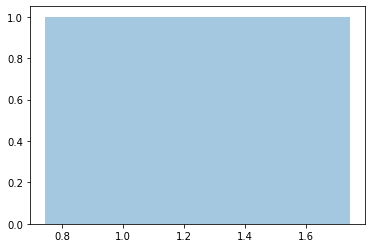

In [6]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.loguniform.html
r = uniform(0.5, 1).rvs()
plot = sns.distplot(r)

#### Ridge

In [7]:
model = Ridge(random_state=0)
params = {'solver': ['svd', 'cholesky', 'lsqr', 'sag'],
          'alpha': loguniform(1e-4, 1000),
          'fit_intercept': [True, False],
          'normalize': [True, False]}

search = RandomizedSearchCV(model, 
                            params, 
                            n_iter=500, 
                            scoring='neg_root_mean_squared_error', 
                            cv=cv, 
                            random_state=0)

results = search.fit(X, y)
print('Best Score: %s' % -results.best_score_)
print('Best Hyperparameters: %s' % results.best_params_)

Best Score: 34.963492879054485
Best Hyperparameters: {'alpha': 514.2644001298286, 'fit_intercept': True, 'normalize': False, 'solver': 'sag'}


#### Random forest

In [8]:
model = RandomForestRegressor()

params = { 'max_depth': [8, 12, 16, 20],
           'max_features': ['auto', 'sqrt'],
           'min_samples_leaf': [5, 10, 16, 20],
           'min_samples_split': [5, 7, 10],
           'n_estimators': [20, 50, 100, 200]}

search = RandomizedSearchCV(model, 
                            params, 
                            n_iter=10, 
                            scoring='neg_root_mean_squared_error', 
                            cv=cv, 
                            random_state=0)

results = search.fit(X, y)
print('Best Score: %s' % -results.best_score_)
print('Best Hyperparameters: %s' % results.best_params_)

Best Score: 48.49223476772152
Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 16}


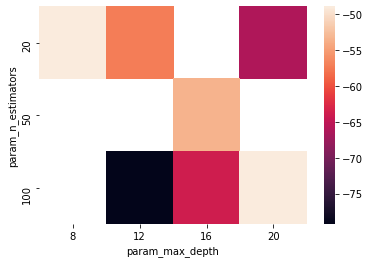

In [9]:
table = pd.pivot_table(pd.DataFrame(search.cv_results_), 
                       values='mean_test_score', 
                       index='param_n_estimators', 
                       columns='param_max_depth')
     
plot = sns.heatmap(table)

## Grid search

In [10]:
from sklearn.model_selection import GridSearchCV

#### Ridge

In [11]:
model = Ridge(random_state=0)

params = {'solver': ['svd', 'cholesky', 'lsqr', 'sag'],
          'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100, 1000],
          'fit_intercept': [True, False],
          'normalize': [True, False]}

search = GridSearchCV(model, 
                      params, 
                      scoring='neg_root_mean_squared_error', 
                      n_jobs=-1, 
                      cv=cv)

results = search.fit(X, y)
print('Best Score: %s' % -results.best_score_)
print('Best Hyperparameters: %s' % results.best_params_)

Best Score: 35.05034793056852
Best Hyperparameters: {'alpha': 1000, 'fit_intercept': True, 'normalize': False, 'solver': 'svd'}


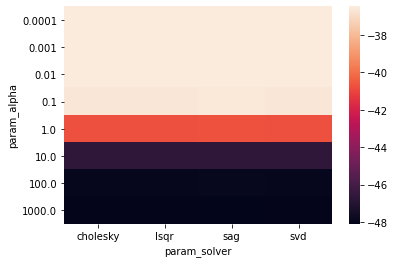

In [12]:
table = pd.pivot_table(pd.DataFrame(search.cv_results_), 
                       values='mean_test_score', 
                       index='param_alpha', 
                       columns='param_solver')
     
plot = sns.heatmap(table)

#### Random forest

In [13]:
model = RandomForestRegressor()

params = { 'max_depth': [8, 16, 20],
           'max_features': ['auto', 'sqrt'],
           'n_estimators': [100, 120, 140]}

search = GridSearchCV(model, 
                      params, 
                      scoring='neg_root_mean_squared_error', 
                      n_jobs=-1, 
                      cv=cv)


results = search.fit(X, y)
print('Best Score: %s' % -results.best_score_)
print('Best Hyperparameters: %s' % results.best_params_)

Best Score: 42.6134005690374
Best Hyperparameters: {'max_depth': 20, 'max_features': 'sqrt', 'n_estimators': 100}


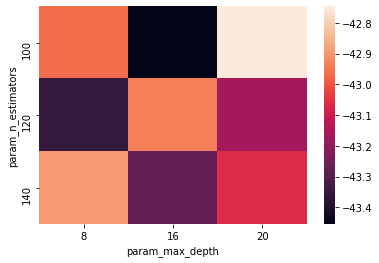

In [14]:
table = pd.pivot_table(pd.DataFrame(search.cv_results_), 
                       values='mean_test_score', 
                       index='param_n_estimators', 
                       columns='param_max_depth')
     
plot = sns.heatmap(table)

## Automated: Bayesian optimization

# https://mlconf.com/blog/lets-talk-bayesian-optimization/
![bayesian optimization](https://mlconf.com/wp-content/uploads/2018/11/sigopt_mlconf_post_pic.png)

!['BO 1'](https://mlconf.com/wp-content/uploads/2018/11/function_and_points_observed.png)
!['BO 2'](https://mlconf.com/wp-content/uploads/2018/11/gp_model.png)

![SegmentLocal](figures/contour_plot.gif "segment")

In [15]:
#!pip install hyperopt
from sklearn.model_selection import cross_val_score
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

#### Ridge

In [16]:
params = {'solver': hp.choice('solver', ['svd', 'cholesky', 'lsqr', 'sag']),
          'alpha': hp.uniform('alpha', 1e-5, 1e3),
          'fit_intercept':  hp.choice('fit_intercept', [True, False]),
          'normalize':  hp.choice('normalize', [True, False])}


def objective(params):
    model = Ridge(solver = params['solver'],
                  alpha = params['alpha'],
                  fit_intercept = params['fit_intercept'],
                  normalize = params['normalize'],                  
                  random_state=0)
    
    score = cross_val_score(model, X, y, cv=cv, scoring='neg_root_mean_squared_error').mean()

    return {'loss': -score, 'status': STATUS_OK }

trials = Trials()
best = fmin(fn=objective,
            space=params,
            algo=tpe.suggest,
            max_evals=100,
            trials=trials)

print('Best Score: %s' % best)

100%|██████████████████████████████████████████████| 100/100 [00:04<00:00, 23.87trial/s, best loss: 34.961665572858514]
Best Score: {'alpha': 585.4738359319784, 'fit_intercept': 0, 'normalize': 1, 'solver': 3}


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

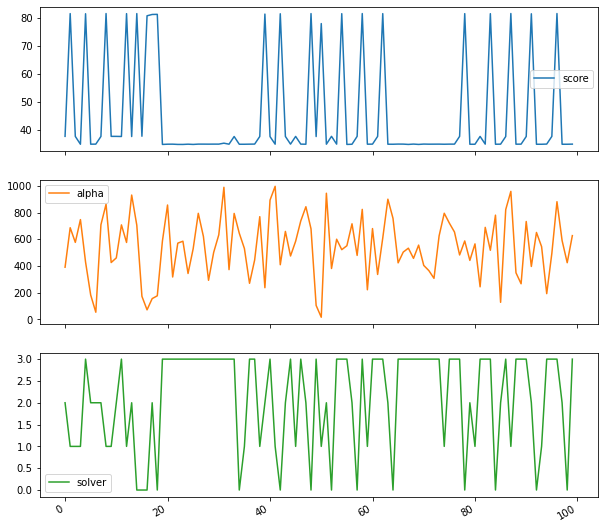

In [17]:
tpe_results = np.array([[x['result']['loss'],
                      x['misc']['vals']['alpha'][0],
                      x['misc']['vals']['solver'][0]] for x in trials.trials])

table = pd.DataFrame(tpe_results, columns=['score', 'alpha', 'solver'])

table.plot(subplots=True,figsize=(10, 10))

<AxesSubplot:xlabel='alpha', ylabel='score'>

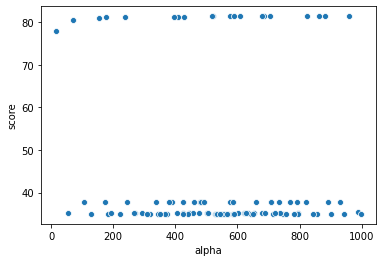

In [18]:
sns.scatterplot(table.alpha, table.score)

#### Random forest

In [22]:
params = { 'max_depth':hp.quniform('max_depth',15, 20, 1),
           'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
           'min_samples_leaf': hp.uniform ('min_samples_leaf', 0, 0.5),
            'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
            'n_estimators':hp.quniform('n_estimators',100,300,20)}

def objective(params):
    model = RandomForestRegressor(max_depth = int(params['max_depth']),
                                 max_features = params['max_features'],
                                 min_samples_leaf = params['min_samples_leaf'],
                                 min_samples_split = params['min_samples_split'],
                                 n_estimators = int(params['n_estimators']) )
    
    score = cross_val_score(model, X, y, cv=3, scoring='neg_root_mean_squared_error',).mean()
    
    return {'loss': -score, 'status': STATUS_OK }


trials = Trials()
best = fmin(fn=objective,
            space=params,
            algo=tpe.suggest,
            max_evals=150,
            trials=trials)


print('Best Score: %s' % best)

100%|███████████████████████████████████████████████| 150/150 [01:57<00:00,  1.28trial/s, best loss: 52.00178496851047]
Best Score: {'max_depth': 18.0, 'max_features': 1, 'min_samples_leaf': 0.02238053499491688, 'min_samples_split': 0.16881293278120002, 'n_estimators': 280.0}


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

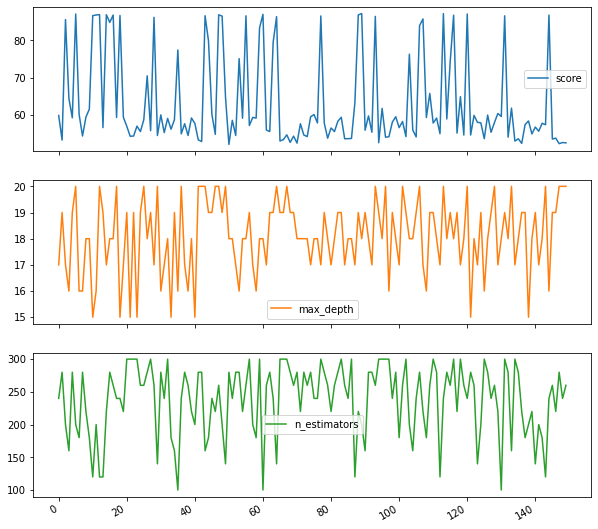

In [23]:
tpe_results = np.array([[x['result']['loss'],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0]] for x in trials.trials])

table = pd.DataFrame(tpe_results, columns=['score', 'max_depth', 'n_estimators'])

table.plot(subplots=True,figsize=(10, 10))

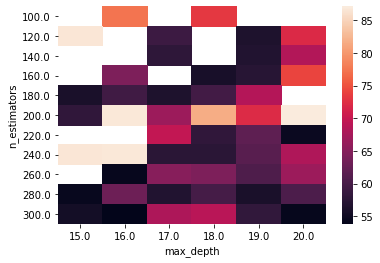

In [24]:
pivot_table = pd.pivot_table(table,
                       values='score', 
                       index='n_estimators', 
                       columns='max_depth')
   
plot = sns.heatmap(pivot_table)

#### Other packages
* optuna, tune, TPOT..